# Preventing Customer Churn by Optimizing Incentive Programs

----
## Table of contents

1. [Background](#Background)
2. [Setup](#Setup)
3. [Data Exploration](#Data-Exploration)
4. [Model Training](#Train)
6. [Model Hosting](#Host)
7. [Assess and optimize](#Assess-and-optimize)
8. [Summary](#Summary)


---

## Background

_This notebook has been adapted from [Amazon SageMaker Examples - Customer Churn](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/xgboost_customer_churn). That notebook had been adapted from the [AWS blog post](https://aws.amazon.com/blogs/ai/predicting-customer-churn-with-amazon-machine-learning/) and [AWS notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb)._

*This notebook also builds on the AWS blog [Gain customer insights using Amazon Aurora machine learning](https://aws.amazon.com/blogs/machine-learning/gain-customer-insights-using-amazon-aurora-machine-learning/), which focused on integrating churn information into the customer service response process, offering selected customers an incentive.  For ease of experimentation, this notebook has been built to run stand-alone, but the methods developed here are intended for integration into the environment of the prior blog.*

*In this version of the notebook, in addition to building the predictive model we explore the key question: How do we create an optimal incentive program that we (as the provider) think is most likely to reduce churn, with the minimum cost to us?*

Losing customers is costly for any business.  Identifying unhappy customers early on gives the business a chance to offer them incentives to stay.  This notebook describes using machine learning (ML) for the automated identification of unhappy customers, also known as customer churn prediction. ML models rarely give perfect predictions though, so this notebook is also about how to incorporate the relative costs of prediction mistakes when determining the financial outcome of using ML.

We use an example of churn that is familiar to all of us – leaving a mobile phone operator.  Seems like I can always find fault with my provider du jour! And if my provider knows that I’m thinking of leaving, it can offer timely incentives – I can always use a phone upgrade or perhaps have a new feature activated – and I might just stick around. Incentives are often much more cost effective than losing and reacquiring a customer.

*The first sections of the notebook are identical to the source XGBoost notebook. Substantial differences begin at the heading, "Assessing business impact..."*

---

## Setup

_This notebook was created and tested on an __ml.m4.xlarge__ notebook instance._

Import the libraries:

In [1]:
import os
import sys
import boto3
import re
import sagemaker

# To get the container for training
from sagemaker.amazon.amazon_estimator import get_image_uri
# To run predictions against the model 
from sagemaker.predictor import csv_serializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

# Data manipulations:
import pandas as pd
import numpy as np

# Data Plotting
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# To mix code and markdown
from IPython.display import Markdown
# from ColorBrewer
plot_color = "#4daf4a"

%matplotlib inline


In [2]:
accountid = boto3.client('sts').get_caller_identity()['Account']
role = sagemaker.get_execution_role()
sess = sagemaker.Session()

# provide a prefix to be attached to the output files in the bucket
prefix = 'sagemaker/xgboost-churn-ecooptimize'

In [3]:
# Please give the name of an existing bucket to use
bucket = 'vmegler-projects'

---
## Data Exploration

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. 


In [4]:
if not os.path.exists("DKD2e_data_sets.zip"):
    !wget http://dataminingconsultant.com/DKD2e_data_sets.zip
    !unzip -o DKD2e_data_sets.zip
else:
    print("File has been already downloaded")

File has been already downloaded


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

- `State`: the US state in which the customer resides, indicated by a two-letter abbreviation; for example, OH or NJ
- `Account Length`: the number of days that this account has been active
- `Area Code`: the three-digit area code of the corresponding customer’s phone number
- `Phone`: the remaining seven-digit phone number
- `Int’l Plan`: whether the customer has an international calling plan: yes/no
- `VMail Plan`: whether the customer has a voice mail feature: yes/no
- `VMail Message`: presumably the average number of voice mail messages per month
- `Day Mins`: the total number of calling minutes used during the day
- `Day Calls`: the total number of calls placed during the day
- `Day Charge`: the billed cost of daytime calls
- `Eve Mins, Eve Calls, Eve Charge`: the billed cost for calls placed during the evening
- `Night Mins`, `Night Calls`, `Night Charge`: the billed cost for calls placed during nighttime
- `Intl Mins`, `Intl Calls`, `Intl Charge`: the billed cost for international calls
- `CustServ Calls`: the number of calls placed to Customer Service
- `Churn?`: whether the customer left the service: true/false

The last attribute, `Churn?`, is known as the target attribute–the attribute that we want the ML model to predict.  Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Preview the first few rows:

In [5]:
# read the customer churn data to pandas DataFrame
pd.set_option('display.max_columns', 25)
churn = pd.read_csv('./Data sets/churn.txt')
# review the top rows
churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


#### Exploring the Data

Let's begin exploring the data. 

_This section is identical to the original notebook, [Amazon SageMaker Examples - Customer Churn](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/xgboost_customer_churn). While data exploration is an important topic, it's not the focus of this walk through. Therefore it's been removed in the interests of brevity, but the actions taken based on the analysis have been kept (i.e., columns kept/removed). Please refer to the original notebook for this section._  

In [6]:
# Now, we'll save a copy of the original dataset, for use later
churn_save = churn.copy()
# Then, we'll add a column for the total customer spend
churn_save['Total Customer Spend'] = churn_save.apply(lambda x: x['Day Charge'] + x['Night Charge'] + x['Eve Charge'] 
                                                      + x['Intl Charge'], axis=1)
churn_save['Area Code'] = churn['Area Code'].astype(object)

In [7]:
churn = churn.drop('Phone', axis=1)
churn['Area Code'] = churn['Area Code'].astype(object)

Let's remove one feature from each of the highly correlated pairs: Day Charge from the pair with Day Mins, Night Charge from the pair with Night Mins, Intl Charge from the pair with Intl Mins:

In [8]:
churn = churn.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Now that we've cleaned up our dataset, let's determine which algorithm to use.  As mentioned above, there appear to be some variables where both high and low (but not intermediate) values are predictive of churn.  In order to accommodate this in an algorithm like linear regression, we'd need to generate polynomial (or bucketed) terms.  Instead, let's attempt to model this problem using gradient boosted trees.  Amazon SageMaker provides an XGBoost container that we can use to train in a managed, distributed setting, and then host as a real-time prediction endpoint.  XGBoost uses gradient boosted trees which naturally account for non-linear relationships between features and the target variable, as well as accommodating complex interactions between features.

Amazon SageMaker XGBoost can train on data in either a CSV or LibSVM format.  For this example, we'll stick with CSV.  It should (documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)):

- Have the predictor variable in the first column
- Not have a header row

Since the model will not have the feature names later, when we explore the results, we will need to assign them from the original data (excluding the target variable)

But first, let's convert our categorical features into numeric features as the algorithm manages only numeric features. Then, we place the outcome as the first column.

In [9]:
model_data = pd.get_dummies(churn)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

And now let's split the data into training, validation, and test sets.  This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

_Note that different splits of the data may create slightly different results. In addition, on different runs against the same data, XGBoost may choose different combinations of features and trees that give similar model performance._ 


In [10]:
train_data, validation_data, test_data = np.split(model_data.sample(frac = 1, random_state = 1729), 
                                                  [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header = False, index = False)
validation_data.to_csv('validation.csv', header = False, index = False)
test_data.to_csv('test.csv', header = False, index = False)

In [11]:
test_data_columns=test_data.columns
test_data_columns
test_data.shape

Index(['Churn?_True.', 'Account Length', 'VMail Message', 'Day Mins',
       'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
       'Intl Mins', 'Intl Calls', 'CustServ Calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'State_WY', 'Area Code_408', 'Area Code_415', 'Area Code_510',
       'Int'l Plan_no', 'Int'l Plan_yes', 'VMail Plan_no', 'VMail Plan_yes'],


(334, 70)

In [12]:
train_data.head()

,Churn?_True.,Account Length,VMail Message,Day Mins,Day Calls,Eve Mins,Eve Calls,Night Mins,Night Calls,Intl Mins,Intl Calls,CustServ Calls,...,State_VT,State_WA,State_WI,State_WV,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes
1095,0,106,0,274.4,120,198.6,82,160.8,62,6.0,3,1,...,0,0,0,0,0,0,0,1,1,0,1,0
608,0,28,0,187.8,94,248.6,86,208.8,124,10.6,5,0,...,0,0,0,0,1,0,1,0,1,0,1,0
2908,1,148,0,279.3,104,201.6,87,280.8,99,7.9,2,2,...,0,0,0,0,0,0,1,0,1,0,1,0
943,0,132,0,191.9,107,206.9,127,272.0,88,12.6,2,1,...,0,0,0,0,0,0,0,1,1,0,1,0
693,0,92,29,155.4,110,188.5,104,254.9,118,8.0,4,3,...,0,0,0,0,0,0,0,1,1,0,0,1


In [13]:
train_data.columns

Index(['Churn?_True.', 'Account Length', 'VMail Message', 'Day Mins',
       'Day Calls', 'Eve Mins', 'Eve Calls', 'Night Mins', 'Night Calls',
       'Intl Mins', 'Intl Calls', 'CustServ Calls', 'State_AK', 'State_AL',
       'State_AR', 'State_AZ', 'State_CA', 'State_CO', 'State_CT', 'State_DC',
       'State_DE', 'State_FL', 'State_GA', 'State_HI', 'State_IA', 'State_ID',
       'State_IL', 'State_IN', 'State_KS', 'State_KY', 'State_LA', 'State_MA',
       'State_MD', 'State_ME', 'State_MI', 'State_MN', 'State_MO', 'State_MS',
       'State_MT', 'State_NC', 'State_ND', 'State_NE', 'State_NH', 'State_NJ',
       'State_NM', 'State_NV', 'State_NY', 'State_OH', 'State_OK', 'State_OR',
       'State_PA', 'State_RI', 'State_SC', 'State_SD', 'State_TN', 'State_TX',
       'State_UT', 'State_VA', 'State_VT', 'State_WA', 'State_WI', 'State_WV',
       'State_WY', 'Area Code_408', 'Area Code_415', 'Area Code_510',
       'Int'l Plan_no', 'Int'l Plan_yes', 'VMail Plan_no', 'VMail Plan_yes'],


Now we'll upload these files to S3.

In [14]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

---
## Train

Moving onto training, first we'll need to specify the locations of the XGBoost algorithm containers.

_This section is identical to the original notebook, [Amazon SageMaker Examples - Customer Churn](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/xgboost_customer_churn)._  

In [15]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost', repo_version = '1.0-1')
print(container)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3


Then, because we're training with the CSV file format, we'll create `s3_input`s that our training function can use as a pointer to the files in S3.

In [16]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters. 
More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [17]:
sess = sagemaker.Session()

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sess)
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        num_round=100)

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-08-28 00:46:51 Starting - Starting the training job...
2020-08-28 00:46:53 Starting - Launching requested ML instances......
2020-08-28 00:48:04 Starting - Preparing the instances for training......
2020-08-28 00:49:11 Downloading - Downloading input data
2020-08-28 00:49:11 Training - Downloading the training image...
2020-08-28 00:49:48 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[00:49:51] 2333x69 matrix with 160977 entries loaded from /opt/ml/i

---
## Host

Now that we've trained the algorithm, let's create a model and deploy it to a hosted endpoint.

In [19]:
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge', endpoint_name='prevent-churn-oda')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

### Evaluate

_This section has minor changes from the original notebook, to set up for the next section. We save the input file, and then add the predictions as a column, so that all customer data is available to us in addition to the prediction._  

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request.  But first, we'll need to setup serializers and deserializers for passing our `test_data` NumPy arrays to the model behind the endpoint.

In [20]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

For simpler traceability to our original dataset given our focus on optimization rather than on improving the ML model, we'll take a section of our saved dataset and use that to make predictions. 

In [21]:
N = 1500 

churn_sample = churn_save.sample(N)
# Convert this subset to dummies for use in inference; but remove columns that may cause dimension explosion
# Note that dummies can be problematic, as all categorical variables must be represented as with the full dataset.
churn_sample_dummies = pd.get_dummies(churn_sample.drop(['Phone', 'Total Customer Spend'], axis=1))
churn_sample_dummies.shape

(1500, 75)

Now, we'll use a simple function to:
1. Loop over our test dataset
1. Split it into mini-batches of rows 
1. Convert those mini-batchs to CSV string payloads
1. Retrieve mini-batch predictions by invoking the XGBoost endpoint
1. Collect predictions and convert from the CSV output our model provides into a NumPy array

In [22]:
# This version of 'predict' allows us to pass a dataset with more columns, and a list of the columns to be used in the prediction
def predict_cost(data, columns, rows=500):
    test_data = data[columns]
    test_data_nolab = test_data.values[:, 1:]
    split_array = np.array_split(test_data_nolab, int(test_data_nolab.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

predictions = predict_cost(churn_sample_dummies, test_data.columns)
predictions

array([0.08631791, 0.14205045, 0.03817179, ..., 0.04258348, 0.15909368,
       0.89470887])

In [23]:
churn_sample['Churn Probability'] = predictions
churn_sample.head(5)

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?,Total Customer Spend,Churn Probability
913,GA,50,408,377-1218,no,yes,24,214.3,129,36.43,289.8,55,24.63,312.5,130,14.06,10.6,4,2.86,1,False.,77.98,0.086318
97,AZ,99,415,327-3954,no,no,0,198.2,87,33.69,207.3,76,17.62,190.9,113,8.59,8.7,3,2.35,4,False.,62.25,0.142050
2935,DC,136,510,353-2763,no,no,0,204.5,63,34.77,208.8,95,17.75,224.0,119,10.08,9.8,2,2.65,0,False.,65.25,0.038172
3203,PA,142,510,340-6221,no,yes,40,230.7,101,39.22,256.8,88,21.83,263.9,92,11.88,6.4,3,1.73,1,False.,74.66,0.118553
1658,UT,111,510,347-4982,no,no,0,191.3,80,32.52,138.5,94,11.77,246.0,107,11.07,6.4,3,1.73,2,False.,57.09,0.018856


----
## Assess and optimize

_This section contains the new material, and is the focus of this blog post._  

We can assess the model performance by looking at the prediction scores, as shown in the original post, [Amazon SageMaker Examples - Customer Churn](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_applying_machine_learning/xgboost_customer_churn). 

While it’s usual to treat this as a binary classification problem (‘1’ or ‘0’), in fact, the real world is less binary: people become “likely to churn” for some time before they actually churn. Loss of “brand loyalty” occurs some time before someone actually buys from a competitor. There's frequently a slow rise in dissatisfaction over time before someone is finally driven to act. Providing the right incentive at the right time can reset a customer's satisfaction.

So how do calculate the minimum incentive that will give the desired result? Rather than providing a single program to all customers, can we save money and gain a better outcome by using variable incentives, customized to a customer's churn probability and value? And if so, how?

We can do so by building on components we've already developed so far.

#### Assigning costs to our predictions

What are the costs for our problem of mobile operator churn? The costs, of course, depend on the specific actions that the business takes. Let's make some assumptions here.

First, we'll assign the true negatives the cost of \\$0. Our model essentially correctly identified a happy customer in this case, and we won’t offer them an incentive. An alternative is to assign the true negatives the actual value of the customer's spend, as this is the customer's contribution to our overall revenue. 

False negatives are the most problematic, because they incorrectly predict that a churning customer will stay. We lose the customer and will have to pay all the costs of acquiring a replacement customer, including foregone revenue, advertising costs, administrative costs, point of sale costs, and likely a phone hardware subsidy. A quick search on the Internet reveals that such costs typically run in the hundreds of dollars so, for the right now, let's assume $500. This is the cost we'll use for each false negative. Our marketing department should be able to give us a value to use here for the overhead, and we have the actual customer spend for each customer in our dataset. 

Finally, we'll give an incentive to customers that our model identifies as churning. At this point let's assume a one-time retention incentive in the amount of \$50. This is the cost we'll apply to both true positive and false positive outcomes. In the case of false positives (the customer is happy, but the model mistakenly predicted churn), we will “waste” the concession. We probably could have spent those dollars more effectively, but it's possible we increased the loyalty of an already loyal customer, so that’s not so bad. We'll be revising this initial approach below.


Let's look at the continuous values of our churn predictions.

(array([1189.,   76.,   41.,   13.,   16.,   15.,   12.,   19.,   57.,
          62.]),
 array([0.00339087, 0.10263557, 0.20188026, 0.30112495, 0.40036965,
        0.49961434, 0.59885903, 0.69810373, 0.79734842, 0.89659311,
        0.99583781]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'Churn prediction score')

Text(0, 0.5, 'Number of customers')

Text(0.5, 1.0, 'Prediction Scores')

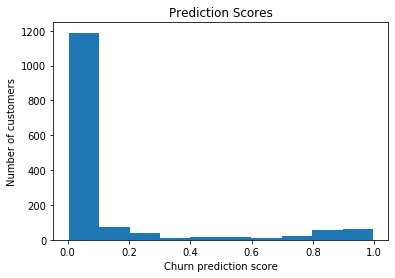

In [24]:
plt.hist(predictions)
plt.xlabel('Churn prediction score')
plt.ylabel('Number of customers')
plt.title('Prediction Scores')
plt.show()

#### Mapping the customer churn threshold

In previous versions of this notebook, we've shown the effect of false negatives that are substantially more costly than false positives. Instead of optimizing for error based on the number of customers, we've used a cost function that looks like this:

```txt
cost_of_replacing_customer * FN(C) + customer_value * TN(C) + incentive_offered * FP(C) + incentive_offered * TP(C)
```

FN(C) means that the false negative percentage is a function of the cutoff, C, and similar for TN, FP, and TP.  We'd like to find the cutoff, C, where the result of the expression is smallest.

Right now we'll start by using the same values for all customers, to give us a starting point for discussion with the business. With the estimates we'll use for right now, this equation becomes:

```txt
$500 * FN(C) + $0 * TN(C) + $50 * FP(C) + $50 * TP(C)
```

A straightforward way to understand the impact of these numbers is to simply run a simulation over a large number of possible cutoffs.  We test 100 possible values in the for loop below.

Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Cost')

Text(0, 0.5, 'Number of customers below cutoff')

Text(0.5, 1.0, 'Cost versus Threshold')

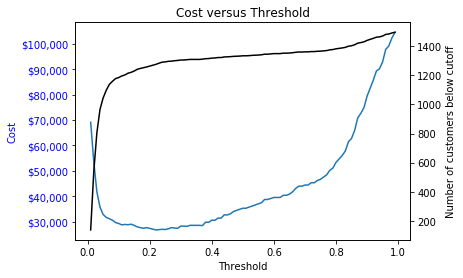

Cost is minimized near a cutoff of: 0.22 for a cost of: $ 26700 for these 1500 customers.
Incentive is paid to 224 customers, for a total outlay of $ 11200
Total customer spend of these customers is $ 15123.499999999998


In [25]:
import matplotlib.ticker as ticker
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
num_below_cutoff = []
fn = 500
tn = 0
fp = 50
tp = 50
for c in cutoffs:
    crsstb = pd.crosstab(index=churn_sample_dummies['Churn?_True.'],       
                                           columns=np.where(predictions > c, 1, 0))
    if crsstb.shape == (2,1):
        print(crsstb.columns)
        if crsstb.columns[0] == 0:   # Then we're missing the '1' column
            crsstb[1] = 0
        else:
            crsstb[0] = 0
    costs.append(np.sum(np.sum(np.array([[tn, tp], [fn, fp]]) * crsstb )))
    num_below_cutoff.append(np.count_nonzero(np.where(predictions <= c, 1, 0)))
    
costs = np.array(costs)
fig, ax = plt.subplots(1, 1)
plt.plot(cutoffs, costs)
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelcolor='b')
plt.xlabel('Threshold')
ax.set_ylabel('Cost',color='b')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of customers below cutoff')  
ax2.plot(cutoffs, num_below_cutoff, color='k')
ax2.tick_params(axis='y', labelcolor='k')

plt.title('Cost versus Threshold')
plt.show()
dex = np.argmin(costs)
incentives_paid_to = len(churn_sample_dummies) - num_below_cutoff[dex]
print('Cost is minimized near a cutoff of:', cutoffs[dex], 'for a cost of: $', np.min(costs), 'for these', len(predictions), 'customers.')
print('Incentive is paid to', incentives_paid_to,'customers, for a total outlay of $', incentives_paid_to * tp)
print('Total customer spend of these customers is $',
          churn_sample[churn_sample['Churn Probability'] > cutoffs[dex]]['Total Customer Spend'].sum())


The above chart shows how picking a threshold too low results in costs skyrocketing as all customers are given a retention incentive.  Meanwhile, setting the threshold too high (e.g., 0.7 or above) results in too many lost customers, which ultimately grows to be nearly as costly. In between, there is a large "grey" area, where perhaps some more nuanced incentives would create better outcomes.  

The overall cost can be minimized at \\$25800 by setting the cutoff to 0.21, which is substantially better than the \\$100k+ we would expect to lose by not taking any action.

We can also calculate the dollar outlay of the program, and compare to the total spend of the customers. Here we can see that paying the incentive to all predicted churn customers will cost \\$12300, and that these customers spend \\$16324. (Your numbers may vary, depending on the specific customers randomly chosen for the sample.)  

What happens if we instead have a smaller budget for our campaign? We'll choose a budget of 1% of total customer monthly spend. 

In [26]:
# C: Incentive Budget equal to a fixed %age of the Total revenue
C = 0.01*np.sum(churn_sample['Total Customer Spend'].values) 

print('Total budget is:', '${:,.2f}'.format(C))
incentive = C / N
print('Per customer incentive is', '${:,.2f}'.format(incentive))

Total budget is: $893.57
Per customer incentive is $0.60


Text(0.5, 0, 'Threshold')

Text(0, 0.5, 'Cost')

Text(0, 0.5, 'Number of customers below cutoff')

Text(0.5, 1.0, 'Cost versus Threshold')

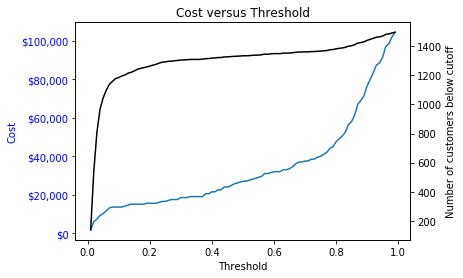

Cost is minimized near a cutoff of: 0.01 for a cost of: $ 1811.9551834 for these 1500 customers.
Incentive is paid to 1363 customers, for a total outlay of $ 811.9551834
Total customer spend of these customers is $ 81586.3


In [27]:
import matplotlib.ticker as ticker
cutoffs = np.arange(0.01, 1, 0.01)
costs = []
num_below_cutoff = []
fn = 500
tn = 0
fp = incentive
tp = incentive
for c in cutoffs:
    crsstb = pd.crosstab(index=churn_sample_dummies['Churn?_True.'],       
                                           columns=np.where(predictions > c, 1, 0))
    if crsstb.shape == (2,1):
        print(crsstb.columns)
        if crsstb.columns[0] == 0:   # Then we're missing the '1' column
            crsstb[1] = 0
        else:
            crsstb[0] = 0
    costs.append(np.sum(np.sum(np.array([[tn, tp], [fn, fp]]) * crsstb )))
    num_below_cutoff.append(np.count_nonzero(np.where(predictions <= c, 1, 0)))
    
costs = np.array(costs)
fig, ax = plt.subplots(1, 1)
plt.plot(cutoffs, costs)
fmt = '${x:,.0f}'
tick = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
ax.tick_params(axis='y', labelcolor='b')
plt.xlabel('Threshold')
ax.set_ylabel('Cost',color='b')

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of customers below cutoff')  
ax2.plot(cutoffs, num_below_cutoff, color='k')
ax2.tick_params(axis='y', labelcolor='k')

plt.title('Cost versus Threshold')
plt.show()

dex = np.argmin(costs)
incentives_paid_to = len(churn_sample_dummies) - num_below_cutoff[dex]
print('Cost is minimized near a cutoff of:', cutoffs[dex], 'for a cost of: $', np.min(costs), 'for these', len(predictions), 'customers.')
print('Incentive is paid to', incentives_paid_to,'customers, for a total outlay of $', incentives_paid_to * tp)
print('Total customer spend of these customers is $',
          churn_sample[churn_sample['Churn Probability'] > cutoffs[dex]]['Total Customer Spend'].sum())

We can see that the cost to us changes. But it's pretty clear that an incentive of ~\\$0.60 is unlikely to change many people's minds.   

For better outcomes, we could even offer a range of incentives to customers that meet different criteria. For example, it's worth more to the business to prevent a high spend customer from churning than a low spend customer. We could also target the "grey area" of customers that have less loyalty and could be swayed by another company's advertising. Let's explore that now. 



## Preventing customer churn using mathematical optimization of incentive programs 

Now let's use a more sophisticated approach to developing our customer retention program. We'd like to tailor our incentives to target the customers most likely to reconsider a "churn" decision. 

Intuitively, we know that we do not need to offer an incentive to customers with a low churn probability. Also, above some threshold, we've already lost the customer's heart and mind, even if they haven't actually left yet. So the best target for our incentive is between those two thresholds - these are the customers we can convince to stay. 

Let's formulate this as a mathematical optimization problem.

The problem under investigation is inherently stochastic in that each customer might churn or not, and might accept the incentive (offer) or not. Stochastic programming [1, 2] is an approach for modeling optimization problems that involve uncertainty. Whereas deterministic optimization problems are formulated with known parameters, real world problems almost invariably include parameters which are unknown at the time a decision should be made. An example would be the construction of an investment portfolio to maximize return. An efficient portfolio would be defined as the portfolio that maximizes the expected return for a given amount of risk (e.g. standard deviation), or the portfolio that minimizes the risk subject to a given expected return [3].

References: [1] S. Uryasev, P. M. Pardalos, Stochastic Optimization: Algorithm and Applications, Kluwer Academic: Norwell, MA, USA, 2001.
[2] John R. Birge and François V. Louveaux. Introduction to Stochastic Programming. Springer Verlag, New York, 1997.
[3] Francis, J. C. and Kim, D. (2013). Modern portfolio theory: Foundations, analysis, and new developments (Vol. 795). John Wiley & Sons.



\begin{align}
    N & : \text{number of customers}
    \\
    i & \in \{1,\ldots,N\}
    \\
    P_i & : \text{profit generated by customer i}
    \\
    \alpha_i & : \text{probability customer i will churn}
    \\
    c_i & : \text{discount or incentive to be offered to customer i}
    \\
    C & = \sum^{N}_{i=1}c_i,  \text{ total retention campaign budget}
    \\
    \gamma_i & \in (0,1), \text{convincing factor for customer i}
    \\
    \beta_i & = 1-e^{-\gamma_i c_i}, \text{ probability customer i will accept the discount $c_i$}
    \\
    f(c_i) & = \sum^{N}_{i=1} P_i(1-\alpha_i) + \sum^{N}_{i=1} \beta_i(\alpha_i P_i - c_i), \text{expected total profit}
\end{align}

Our goal is to optimally allocate the discount 𝑐𝑖 across the 𝑁 customers in order to maximize the expected total profit. Mathematically this is equivalent to the following optimization problem:
\begin{aligned}
& \underset{c_i}{\text{maximize}}
& & f(c_i) \\
& \text{subject to}
& & \sum^{N}_{i=1}c_i \leq C 
\\
&&& c_i \geq 0.
\end{aligned}

For our situation:
* We know the number of customers, N.
* We can use their spend from their customer record as the (upper bound) estimate of the profit they generate, P.
* We can use the churn score from our ML model as an estimate of the probability of churn, alpha. 
* The incentive, c, is what we'd like to calculate.
* We'll use 1% of our total revenue as our campaign budget, C.
* The probability that the customer will be swayed, beta, depends on how convincing the incentive is to the customer - which we've represented as $\gamma$.

That leaves $\gamma$, the convincing factor to be defined, below. 

We set up our inputs: P, profit; alpha, our churn probabilities, from our model above; and C, our campaign budget. 

In [28]:
# P: vector of the total customer spend
P = churn_sample['Total Customer Spend'].values
# alpha: vector of churn probabilities
alpha = churn_sample['Churn Probability'].values

print('Total budget is:', '${:,.2f}'.format(C))

Total budget is: $893.57


Now we can add a variable (gamma) that allows us to specify how likely we think each customer is to accept the offer and not churn - that is, how convincing they find the incentive. 

While this is a matter of business judgment, we can use the graph above to inform that judgment. In this case, the business believes that if the churn probability is below 0.55, they are unlikely to churn, even without an incentive; on the other hand, if the customer's churn probability is above 0.95, the customer has little loyalty and is unlikely to be convinced. The real target for the incentives are the customers with churn probability between 0.55 and 0.95. 

We could include that business insight into the optimization by setting the value for the convincing factor $\gamma$ as follows:

- $\gamma_i$ = 100. This is equivalent to giving less importance as deciding factor to the discount $c_i$  for customers whose churn probability $\alpha_i$ is below 0.55 (they are loyal and less likeley to churn) and/or greater than 0.95 (they will most likely leave despite the retention campaign)
- $\gamma_i$ = 1. This is equivalent to saying that the probability customer i will accept the discount $c_i$ is equal to $\beta = 1-e^{-c_i}$) for customer whose $\alpha_i$ $\in$ [0.55, 0.95]

Once we start to offer these incentives, we can log whether or not each customer accepts the offer and remains a customer. With that information, we can learn this function from experience, and use that learned function to develop the next set of incentives.  

In [29]:
gamma = np.ones(N)
len(np.where(alpha > 0.95)[0])

29

In [30]:
indices_gamma_eq_zero = np.union1d(np.where(alpha > 0.95)[0], np.where(alpha < 0.55)[0])
gamma[indices_gamma_eq_zero] = 100
gamma

array([100., 100., 100., ..., 100., 100.,   1.])

### Solving the optimization problem

There's a variety of open source solvers available that can solve this optimization problem for us. Examples include SciPy scipy.optimize.minimize, or faster open source solvers like GEKKO (https://gekko.readthedocs.io/en/latest/), which is what we use here. For large-scale problems, we would recommend using commercial optimization solvers like CPLEX or GUROBI.

In [31]:
!pip install gekko

     |████████████████████████████████| 10.8 MB 3.8 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


_Note! Due to the stochastic nature of the algorithm, it may occasionally not converge on a solution. In these cases it's often solved by running the algorithm again; or, as a last resort, slightly modifying the value of C has been found to help the algorithm find a solution._

In [32]:
from gekko import GEKKO
m = GEKKO(remote=False)
m.options.SOLVER = 3 #IPOPT Solver
m.options.IMODE = 3

#C=1000
# variable array dimension
# create array
x = m.Array(m.Var,N)
for i in range(N):
    x[i].value = C / N
    x[i].lower = 0
    x[i].upper = 10000000
    
# create parameter
budget = m.Param(value = C)
ival_eq = [m.Intermediate(x[i]) for i in range(N)]
#ival_eq_2 = [m.Intermediate(x[i]) for i in range(int(N/2),N)]
 
m.Equation(sum(ival_eq)==budget)

beta =  [1 - m.exp(-gamma[i] *  x[i]) for i in range(N)]
ival = [m.Intermediate(beta[i] * (alpha[i] * P[i] - x[i])) for i in range(N)]
#ival_2 = [m.Intermediate(beta[i] * (alpha[i] * P[i] - x[i])) for i in range(int(N/2),N)]
m.Obj(-sum(ival))

# minimize objective
m.solve()
print(x)

 ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :         1501
   Intermediates:         3000
   Connections  :            0
   Equations    :         3002
   Residuals    :            2
 
 Number of state variables:           1500
 Number of total equations: -            1
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :           1499
 
 solver            3  not supported
 using default solver: APOPT
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
 
 Iter    Objective  Convergence
    0 -4.81147E+03  4.77485E-12
    1 -7.47394E+03  1.13687E-13
    2 

In [33]:
 # Gekko returns an array of arrays so transforming to array
x = np.array([a[0] for a in x])

We verify that the budget constraint C is met.

In [34]:
print('Total spend is', '${:,.2f}'.format(np.sum(x)), 'compared to our budget of', '${:,.2f}'.format(C))
print('Total customer spend is', '${:,.2f}'.format(churn_sample['Total Customer Spend'].sum()), 'for', len(churn_sample), 'customers.' )

Total spend is $893.57 compared to our budget of $893.57
Total customer spend is $89,356.77 for 1500 customers.


Now we evaluate the expected total profit for the following scenarios:
1. Optimal discount allocation, as calculated by our optimization algorithm
2. Uniform discount allocation - every customer is offered the same incentive
3. No discount

In [35]:
def expected_total_profit(x, gamma, alpha, P):
    # beta: vector of probabilities customer will accept the offer
    beta = 1  - np.exp(-gamma * (x))
    
    return np.sum(P * (1 - alpha)) + np.sum(beta * (alpha * P - x))

In [36]:
expected_total_profit_no_campaign = expected_total_profit(0, gamma, alpha, P)
expected_total_profit_optimal = expected_total_profit(x, gamma, alpha, P)
expected_total_profit_uniform_campaign = expected_total_profit((C/N)*np.ones(N), gamma, alpha, P)

<Figure size 720x432 with 0 Axes>

([<matplotlib.axis.XTick at 0x7f7f04448390>,
 <a list of 3 Text xticklabel objects>)

Text(0.5, 0, 'Budget Allocation Approach')

Text(0, 0.5, 'Expected Total Profit')

<BarContainer object of 3 artists>

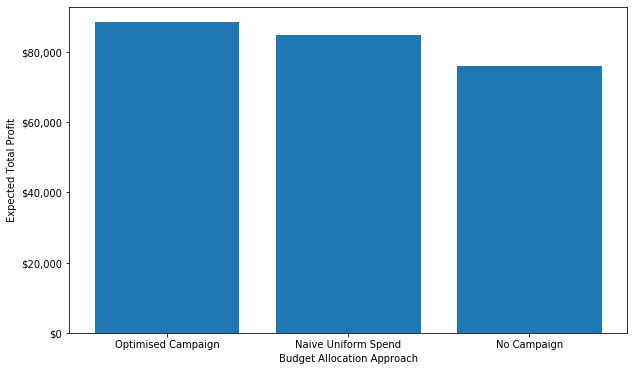

Expected total profit compared to no campaign:  16%
Expected total profit compared to uniform discount allocation:  4%


In [37]:
plt.figure(figsize=(10, 6))
data = [expected_total_profit_optimal, expected_total_profit_uniform_campaign, expected_total_profit_no_campaign]
labels = ['Optimised Campaign', 'Naive Uniform Spend', 'No Campaign']
plt.xticks(range(len(data)), labels)
plt.xlabel('Budget Allocation Approach')
plt.ylabel('Expected Total Profit')
# plt.title('Benefit of Optimisation with N=%i Customers' %N)
plt.bar(range(len(data)), data)
ax = plt.gca()
fmt = '${x:,.0f}'
formatter = ticker.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(formatter)

plt.savefig("Profits from optimisation", transparent=True)
plt.show()

print("Expected total profit compared to no campaign:  %.0f%%" %(100*(expected_total_profit_optimal-expected_total_profit_no_campaign)/expected_total_profit_no_campaign))
print("Expected total profit compared to uniform discount allocation:  %.0f%%" %(100*(expected_total_profit_optimal-expected_total_profit_uniform_campaign)/expected_total_profit_uniform_campaign))

Lastly, we add the discount to our customer data. 

In [38]:
churn_sample['Convincing Factor'] = gamma
churn_sample['Optimal Discount'] = x

Text(0.5, 0, 'Discount in $')

Text(0, 0.5, '# of Subscribers Offered Discount')

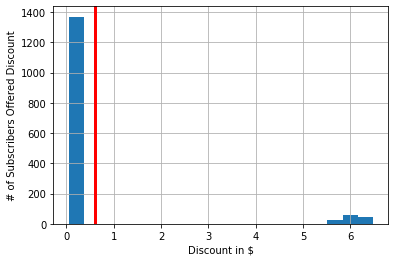

In [39]:
churn_sample['Optimal Discount'].hist(bins=20)
plt.axvline(x=C/N, linewidth=3, color='r')
plt.xlabel('Discount in $')
plt.ylabel('# of Subscribers Offered Discount')

We can see that this graph mirrors the histogram of churn probabilies, above: a large number of people are unlikely to churn, and they are offered a very small discount. A smaller number of people are likely to churn, and they are offered a larger discount.

The vertical line shows the discount offered by a naive, uniform allocation of the budget across all customers.  



Now, for each customer we can see their total spend, and the optimal incentive to offer that customer. We can see that the discount varies by churn probability, and we're assured that the incentive campaign will fit within our budget.



In [40]:
churn_sample[['State', 'Area Code', 'Phone', 'Churn?', 'Total Customer Spend', 'Churn Probability', 'Optimal Discount', 
              'Convincing Factor']].sort_values(by='Optimal Discount', ascending=False).head(15)

,State,Area Code,Phone,Churn?,Total Customer Spend,Churn Probability,Optimal Discount,Convincing Factor
832,SC,408,335-1874,True.,83.14,0.917121,6.478214,1.0
2708,MI,408,389-4608,True.,80.44,0.944693,6.474639,1.0
901,CT,510,370-5527,True.,85.46,0.885804,6.470634,1.0
331,MT,415,387-5453,True.,78.93,0.947161,6.457338,1.0
859,AL,408,374-9203,True.,79.37,0.940146,6.455318,1.0
1893,IN,510,330-9354,True.,78.80,0.917642,6.421701,1.0
2942,GA,415,328-5188,True.,80.52,0.896742,6.420118,1.0
978,VT,415,394-7447,True.,83.52,0.863931,6.419509,1.0
2210,UT,415,367-3220,True.,78.22,0.920567,6.417463,1.0
1933,PA,408,377-5043,True.,79.03,0.907595,6.413227,1.0


In [41]:
churn_sample[['State', 'Area Code', 'Phone', 'Churn?', 'Total Customer Spend', 'Churn Probability', 'Optimal Discount', 
              'Convincing Factor']].sample(15)

,State,Area Code,Phone,Churn?,Total Customer Spend,Churn Probability,Optimal Discount,Convincing Factor
2975,WV,415,382-3512,False.,50.73,0.014496,0.064396,100.0
2702,VT,510,333-9664,False.,54.50,0.022015,0.069551,100.0
1258,RI,510,422-8268,False.,68.17,0.051344,0.080563,100.0
70,NJ,408,359-1231,False.,72.08,0.036865,0.077753,100.0
285,SD,408,412-1194,False.,55.56,0.017662,0.067447,100.0
487,IN,415,363-3911,False.,73.41,0.061725,0.083185,100.0
2149,IA,415,341-6743,False.,74.54,0.061287,0.083268,100.0
1497,MT,510,393-3274,False.,55.45,0.025156,0.071119,100.0
2444,TX,415,408-9572,False.,76.81,0.066599,0.084449,100.0
2347,IL,415,340-6908,True.,60.66,0.837967,6.042959,1.0


---

Depending on the size of the total budget we allocate, we may occasionally find that we’re offering all customers a discount. This discount allocation problem reminds us of the water-filling algorithm in wireless communications [4,5], where the problem is of maximizing the mutual information between the input and the output of a channel composed of several subchannels (such as a frequency-selective channel, a time-varying channel, or a set of parallel subchannels arising from the use of multiple antennas at both sides of the link) with a global power constraint at the transmitter. More power is allocated to the channels with higher gains to maximize the sum of data rates or the capacity of all the channels. The solution to this class of the problems can be interpreted by a vivid description as pouring limited volume of water into a tank, the bottom of which has the stair levels determined by the inverse of the sub-channel gains. 

Unfortunately our problem does not have an intuitive explanation as for the water-filling problem. This is due to the fact that, because of the nature of the objective function, the system of equations and inequalities corresponding to the KKT conditions [6] does not admit a closed form solution.

The optimal incentives calculated here are the result of an optimization routine designed to maximize an economic figure, which is the expected total profit. While this approach provides a principled way for Marketing teams to make systematic, quantitative and analytics-driven decisions, it is also important to recall that the objective function to be optimized is a proxy measure to the actual total profit. It goes without saying that we cannot compute the actual profit based on future decisions (e.g. this would paradoxically imply maximizing the actual return based on future values of the stocks). But we can explore new ideas using techniques such as the potential outcomes work [7], which could be leveraged to design strategies for back-testing of our solution.


References: [4] T. M. Cover and J. A. Thomas, Elements of Information Theory. New York: Wiley, 1991.
[5] D. P. Palomar and J. R. Fonollosa, “Practical algorithms for a family of water-filling solutions,” IEEE Trans. Signal Process., vol. 53, no. 2, pp. 686–695, Feb. 2005.
[6] S. Boyd and L. Vandenberghe. Convex optimization. Cambridge university press, 2004.
[7] Imbens, G. W. and D. B. Rubin (2015): Causal Inference for Statistics, Social, and Biomedical Sciences, Cambridge University Press.


## Conclusion

We’ve now taken another step towards preventing customer churn. We’ve built on the prior blog, where we integrated our customer data with our ML model to predict churn. We can now experiment with variations on this optimization equation, and see the effect of different campaign budgets or even different theories of how they should be modeled.

To gather more data on effective incentives and customer behavior, we could also test several campaigns against different subsets of our customers. We can collect their responses – do they churn after being offered this incentive, or not? – and use that data in a future ML model to further refine the incentives offered. We can use this data to learn what kinds of incentives convince customers with different characteristics to stay, and then use that new function within this optimization.

Now, we’re empowering Marketing with the tools to make data-driven decisions that they can quickly turn into action. This approach can drive fast iterations on incentive programs, moving at the speed with which our customers make decisions. Over to you, Marketing!


### Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [42]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)